In [1]:
# check GPU resource
!nvidia-smi

Sat Apr 22 08:14:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# install requirements for using stable diffusion
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

**pre-trained model** 에 포함된 컴포넌트 폴더는 아래와 같음
- `text_encoder`: Stable diffusion 은 CLIP 을 사용 (Diffusion 모델에 따라 BERT 등 다른 인코더를 사용할 수 있음)
- `tokenizer`. `text_encoder` 모델에 맞는 토크나이저
- `scheduler`: 스케줄링 알고리즘 - 이미지를 학습 하는 과정에서 점진적으로 노이즈를 추가하는 역할을 함.
- `unet`: 입력의 잠재 표현(latent representation)을 생성하는 데 사용되는 모델
- `vae`: latent representation 을 실제 이미지로 디코딩하는 데 사용하는 auto encoder

`subfolder` argument 를 통해 해당 폴더에 저장된 컴포넌트를 로드하는 방식으로 사용함

In [3]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# autoencoder 모델 로드
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# text_encoder, tokenizer 로드
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# UNet 모델 로드
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.5.layer_norm2.bias', 'vision_model.encoder.layers.20.layer_norm1.weight', 'vision_model.encoder.layers.19.layer_norm1.bias', 'vision_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.encoder.layers.15.self_attn.v_proj.bias', 'vision_model.encoder.layers.7.mlp.fc1.bias', 'vision_model.encoder.layers.12.self_attn.out_proj.bias', 'vision_model.encoder.layers.4.mlp.fc1.bias', 'vision_model.encoder.layers.10.self_attn.v_proj.bias', 'vision_model.encoder.layers.14.mlp.fc2.bias', 'vision_model.embeddings.position_ids', 'vision_model.encoder.layers.13.self_attn.out_proj.weight', 'vision_model.encoder.layers.19.layer_norm2.bias', 'vision_model.encoder.layers.9.layer_norm1.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.bias', 'vision_model.encoder.layers.6.self_attn.k_proj.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.weigh

In [4]:
from diffusers import LMSDiscreteScheduler

# K-LMS 스케줄러 사용 (기본적으로는 PNDM 스케줄러를 사용한다)
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# 모듈들을 GPU 로 옮겨줌 
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

In [5]:
prompt = ["white church building on mountain, with some warm highlights to give the image a lively and cheerful feel."]

height = 512                        # Stable Diffusion 기본값
width = 512                         # Stable Diffusion 기본값
num_inference_steps = 100           # 이미지 denoising 하는 스텝 수
guidance_scale = 7.5                # classifier free guidance - 높을 수록 prompt 에 잘 매칭되는 이미지를 생성하도록 하지만, 다양성은 떨어짐. 
generator = torch.manual_seed(32)
batch_size = 1


# prompt로부터 텍스트 임베딩 도출 - UNet 모델의 입력값으로 쓰임
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# unconditional text embedding (padding token)
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   

# 두개를 합침
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [6]:
# 랜덤 노이즈 생성 - 나중에 512 * 512 의 실제 이미지로 변환됨
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents.shape

torch.Size([1, 4, 64, 64])

In [7]:
# 스케줄러 num_inference_steps 설정 - 이 과정으로 인해 sigma 계산됨
scheduler.set_timesteps(num_inference_steps)
# K-LMS 스케줄러의 경우 latent 와 sigma 를 곱해주어야 함
latents = latents * scheduler.init_noise_sigma

In [8]:
# Denoising

from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # classifier-free guidance 를 사용하는 경우 latent 확장
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # noise residual 을 예측
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # guidance 수행
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

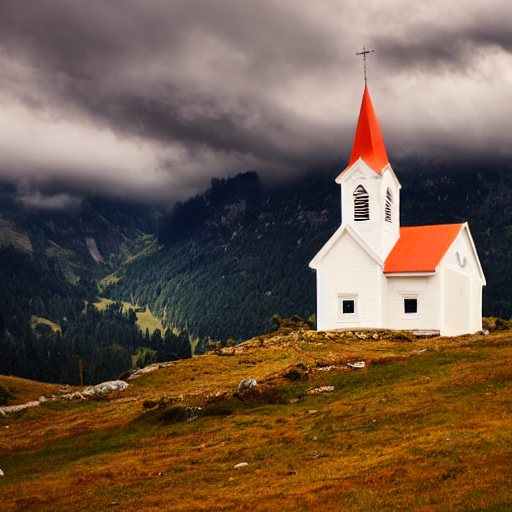

In [9]:
# VAE 를 통해 latent 를 real image 로 변환
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

# 이미지를 PIL 형식으로 변환
from PIL import Image
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]